In [97]:
%load_ext autoreload
%autoreload 2

import torch
import tqdm
import gpytorch


import numpy as np
from ase import io
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1]:
import sys
sys.path.append("../../fande") # Adds higher directory to python modules path.
sys.path.append("..") # Adds higher directory to python modules path.

In [100]:
path = os.getcwd()

print(path)

/home/dlb/coding/shared_coding/repos/chem-gp/saddle-dynamics/notebooks


In [545]:
from fande.data import FandeDataModule

### Parsing and loading data:

In [15]:
%load_ext autoreload
%autoreload 2

from sdynamics.load import parse_trajectories, parse_forces, flatten_trj_dictionaries

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [625]:
trajectories, energies_trj, trj_files_basenames = parse_trajectories(traj_folder="../data/dynamics/ene_grad_fitting/data/trj/")
forces_trj = parse_forces(forces_path = '../data/dynamics/ene_grad_fitting/data/grad/', trj_files_basenames = trj_files_basenames)

Reading trajectory files...


100%|██████████| 50/50 [00:18<00:00,  2.77it/s]

Trajectory files reading done!
Reading .npy files with forces...
Reading .npy files with forces done!


In [626]:
traj, energies, forces = flatten_trj_dictionaries(trajectories, energies_trj, trj_files_basenames, forces_trj)

Flattening done!


### Prepare training/test datasets:

In [917]:
# Training data:
# training_indices = np.sort(  np.random.choice(np.arange(0,10_000), 10000, replace=False) )
training_indices = np.sort(  np.arange(0, 1_000, 7) )  
traj_train = [traj[i] for i in training_indices]
energies_train = energies[training_indices]
forces_train = forces[training_indices]
train_data = {'trajectory': traj_train, 'energies': energies_train, 'forces': forces_train}

#Test data:
# test_indices = np.sort(  np.random.choice(np.arange(0,92795), 200, replace=False) ) 
test_indices = np.sort(  np.arange(0,1_000,1) ) 
traj_test = [traj[i] for i in test_indices]
energies_test = energies[test_indices]
forces_test = forces[test_indices]
test_data = {'trajectory': traj_test, 'energies': energies_test, 'forces': forces_test}

In [918]:
from fande.data import FandeDataModuleASE


hparams = {
    'dtype' : 'float64',
    'device' : 'gpu'
}

fdm = FandeDataModuleASE(train_data, test_data, hparams, atoms_forces=None)

In [919]:
soap_params = {
    'species': ["H", "C"],
    'periodic': False,
    'rcut': 3.0,
    'sigma': 0.5,
    'nmax': 5,
    'lmax': 5,
    'average': "outer",
    'crossover': True,
    'dtype': "float64",
    'n_jobs': 10,
    'sparse': False,
    'positions': [0,2,3,6]
}

fdm.calculate_invariants(soap_params)

Total length of train traj is 143
Starting SOAP calculation...
SOAP calculation done!
Total length of test traj is 1000
Starting SOAP calculation...
SOAP calculation done!
(143, 17, 3, 330)
(143, 330)


In [920]:
fdm.train_DX.shape

torch.Size([7293, 330])

### Fitting Forces:

In [928]:
from fande.models import ModelForces, ModelEnergies, MyCallbacks
from torch.utils.data import DataLoader, TensorDataset, random_split
from pytorch_lightning import Trainer, seed_everything
import numpy as np
# seed_everything(42, workers=True)

train_DX = fdm.train_DX
train_F = fdm.train_F
test_DX = fdm.test_DX
test_F = fdm.test_F

# ind_slice = np.sort( np.concatenate( 
#     ( np.arange(0,4800), np.arange(11*4800,12*4800), np.random.choice(np.arange(4800,59200), 300, replace=False) ) 
#     ) )

ind_slice = np.sort(  np.random.choice(np.arange(0,train_F.shape[0]), 7_000, replace=False) ) 
# ind_slice = np.sort(  np.arange(0,2550) ) 
# ind_slice = np.sort(  np.arange(0,train_F.shape[0]) ) 


train_dataset = TensorDataset(train_DX[ind_slice], train_F[ind_slice])
train_loader = DataLoader(train_dataset, batch_size=100_000)

model_f = ModelForces(train_DX[ind_slice], train_F[ind_slice], hparams, 0.05)

trainer_f = Trainer(
    gpus=1, 
    max_epochs=100, 
    precision=64,
    weights_summary='full', 
    callbacks=[MyCallbacks()])

trainer_f.fit(model_f, train_loader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                                                      | Type                       | Params
----------------------------------------------------------------------------------------------------------
0  | likelihood                                                | GaussianLikelihood         | 1     
1  | likelihood.noise_covar                                    | HomoskedasticNoise         | 1     
2  | likelihood.noise_covar.raw_noise_constraint               | GreaterThan                | 0     
3  | likelihood.noise_covar.raw_noise_constraint._transform    | Softplus                   | 0     
4  | model                                                     | ExactGPModelForces         | 333   
5  | model.covar_module                                        | ScaleKernel                | 331   
6  | model.covar_module.base_kerne


 setup() callback called...
Epoch 99: 100%|██████████| 1/1 [00:01<00:00,  1.24s/it, loss=-0.468, v_num=172] 

 teardown() callback called...


### Predictions on test data:

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/dlb/anaconda3/envs/pyc/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:110: UserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 28 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.




 setup() callback called...

 on_predict_start() callback called...
Predicting: 100%|██████████| 1/1 [00:02<?, ?it/s]

 teardown() callback called...


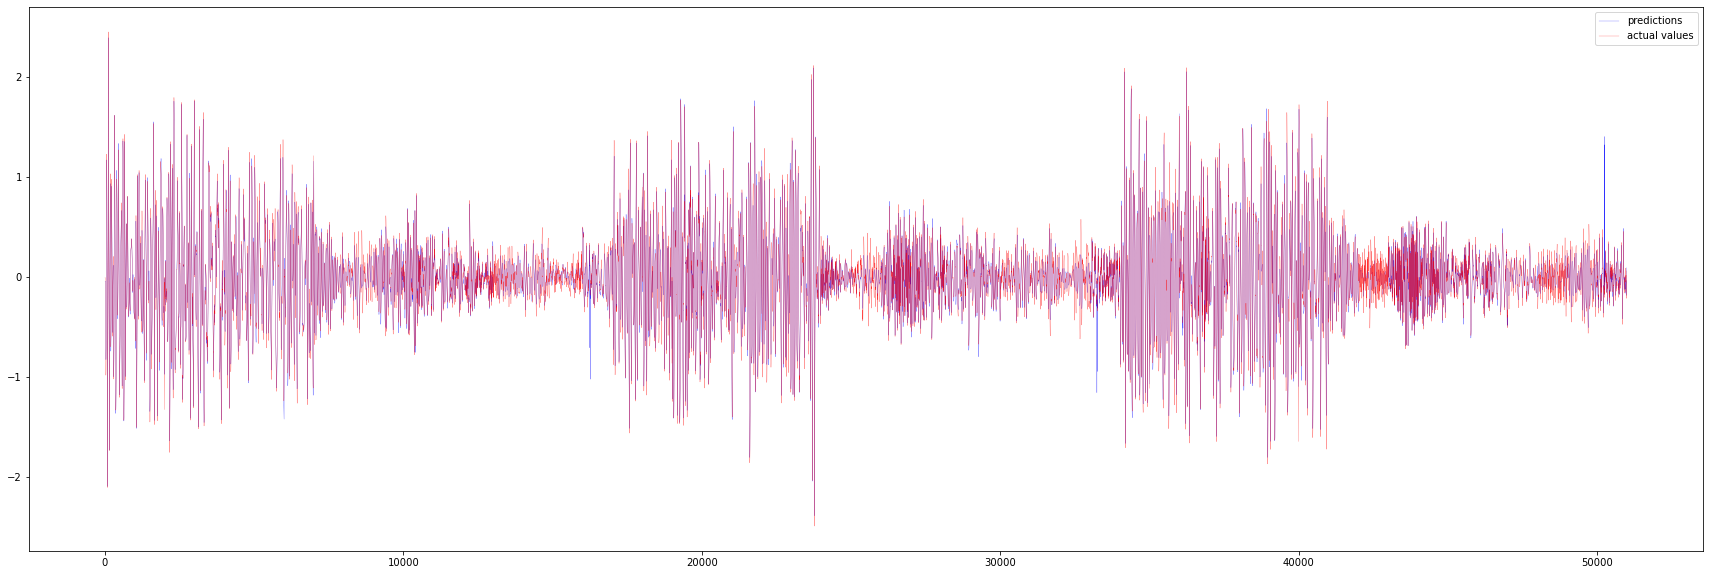

Forces MAE: 0.0536
Forces MSE: 0.0057


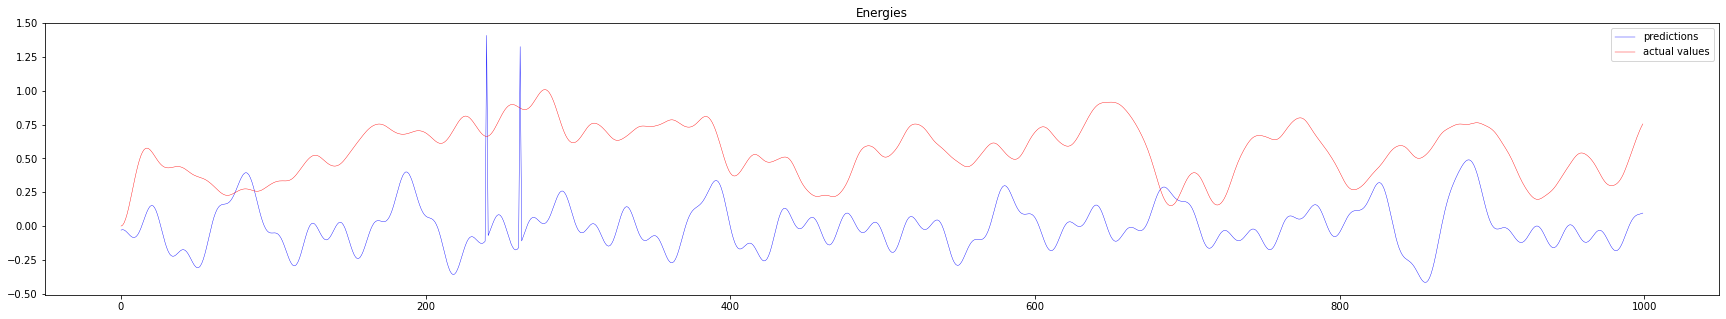

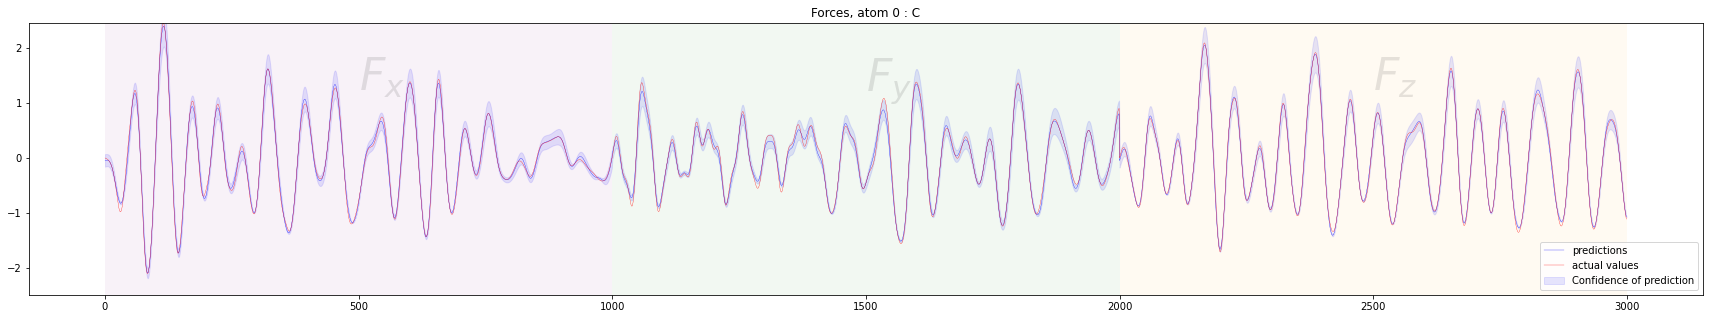

Forces MAE: 0.0377
Forces MSE: 0.0025
Cumulative uncertainty: 645.3627


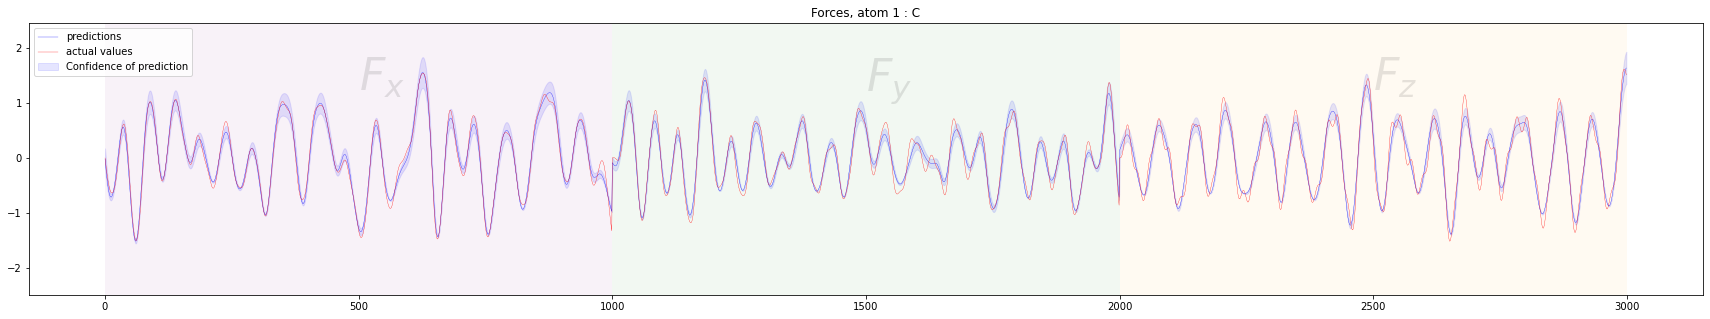

Forces MAE: 0.0900
Forces MSE: 0.0130
Cumulative uncertainty: 492.0309


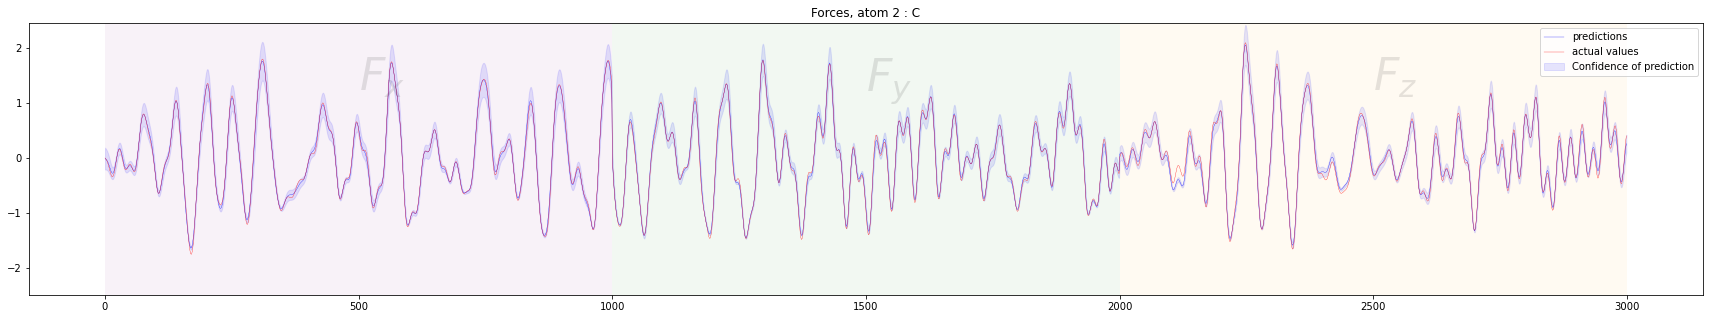

Forces MAE: 0.0336
Forces MSE: 0.0021
Cumulative uncertainty: 690.6948


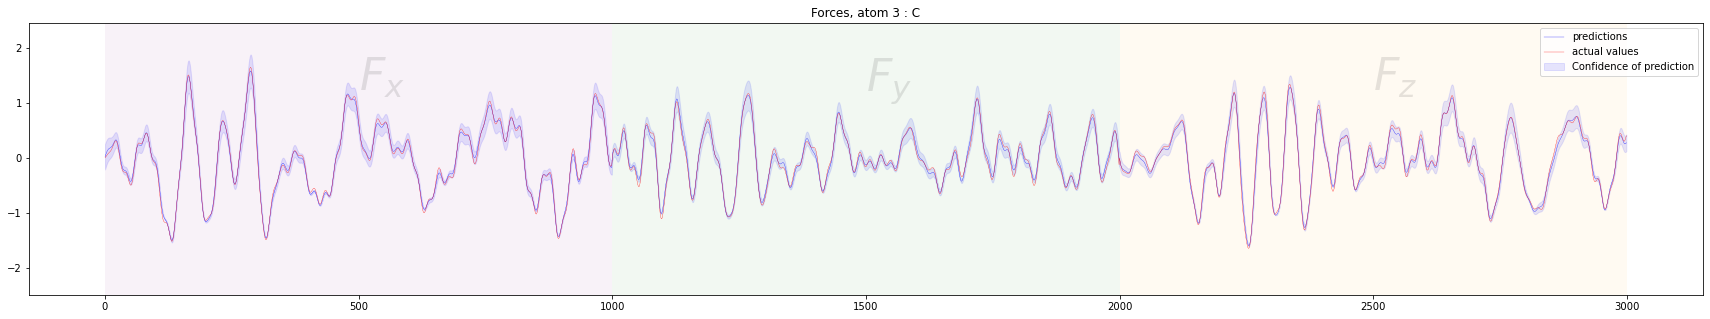

Forces MAE: 0.0379
Forces MSE: 0.0022
Cumulative uncertainty: 646.2069


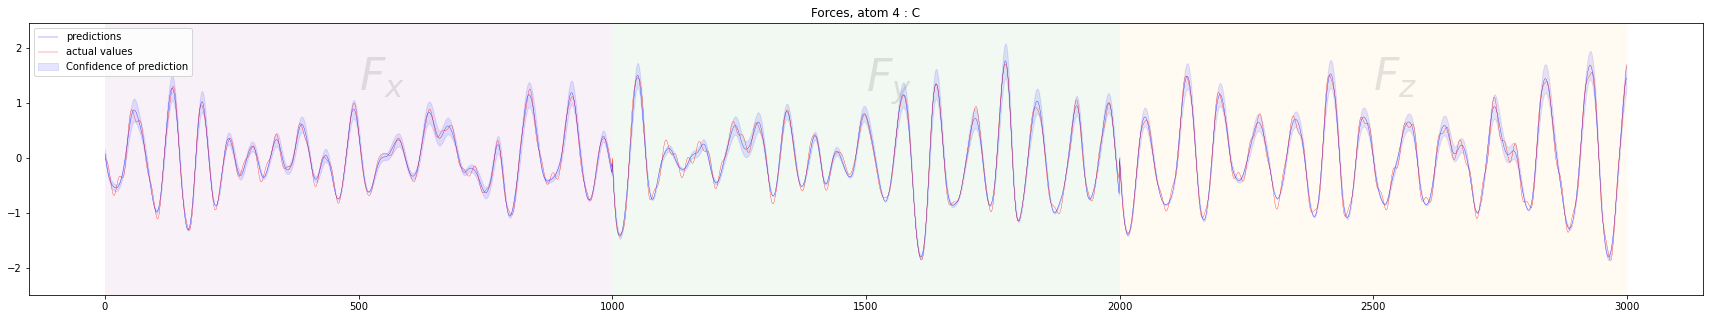

Forces MAE: 0.0709
Forces MSE: 0.0072
Cumulative uncertainty: 512.2138


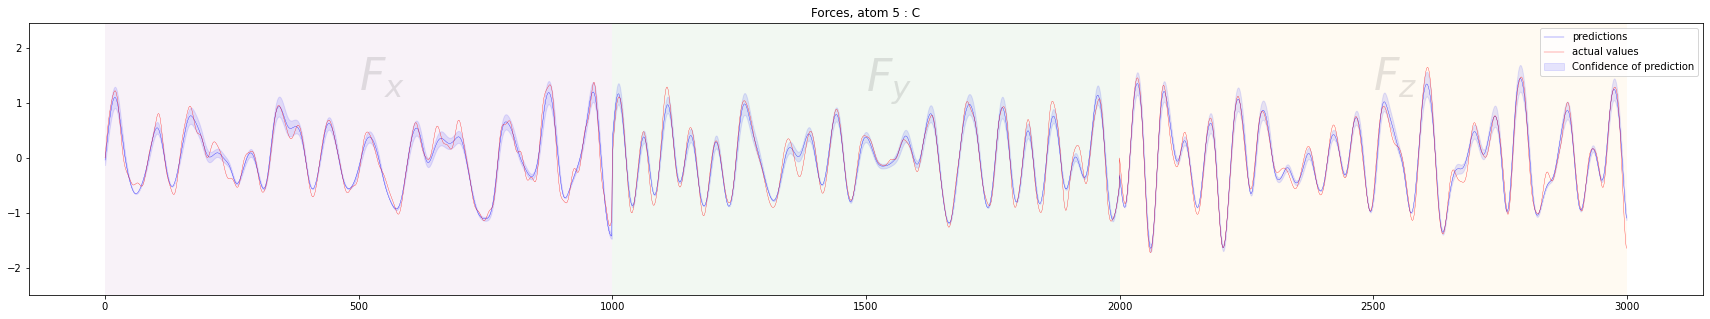

Forces MAE: 0.0935
Forces MSE: 0.0146
Cumulative uncertainty: 456.1070


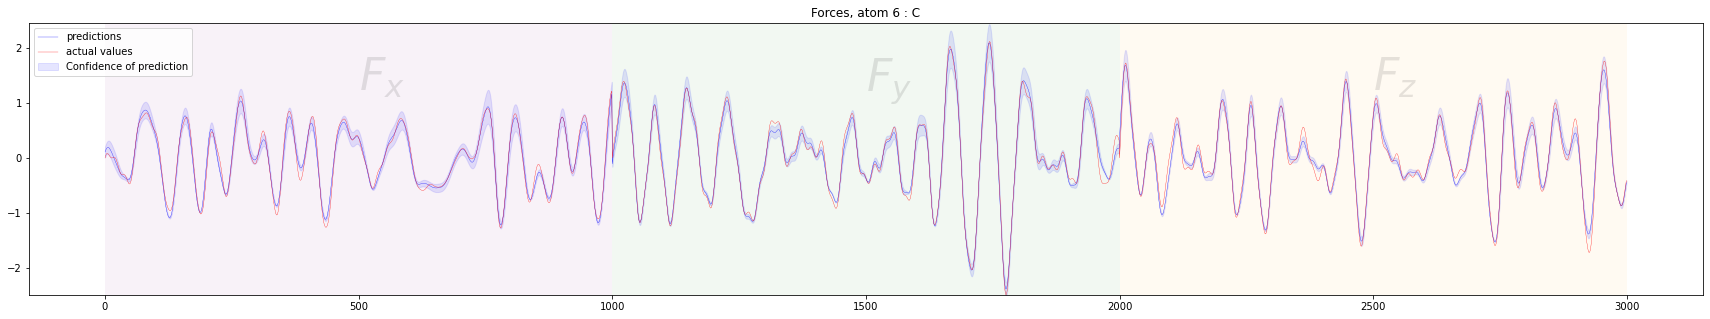

Forces MAE: 0.0685
Forces MSE: 0.0081
Cumulative uncertainty: 520.8003


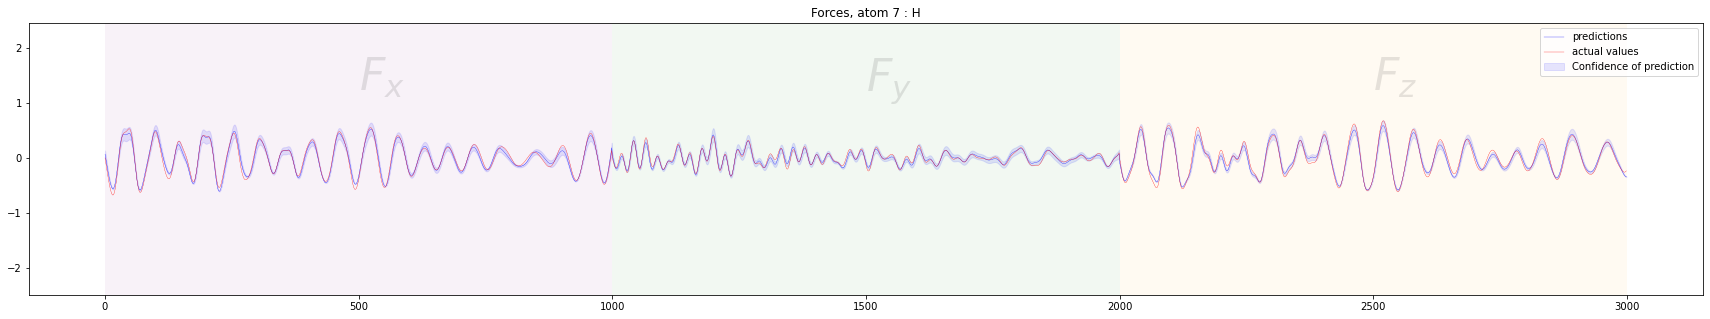

Forces MAE: 0.0370
Forces MSE: 0.0023
Cumulative uncertainty: 296.7205


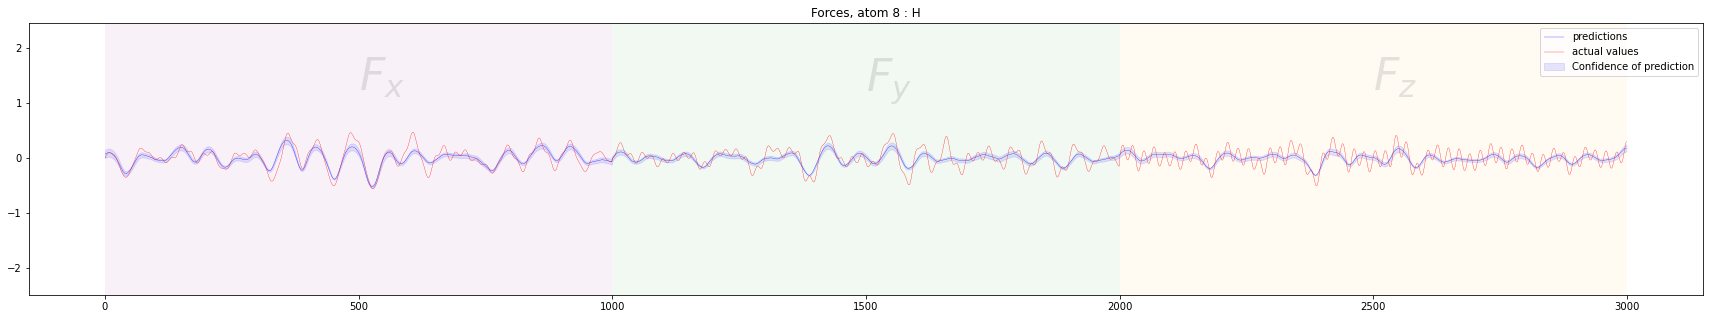

Forces MAE: 0.0930
Forces MSE: 0.0137
Cumulative uncertainty: 229.0114


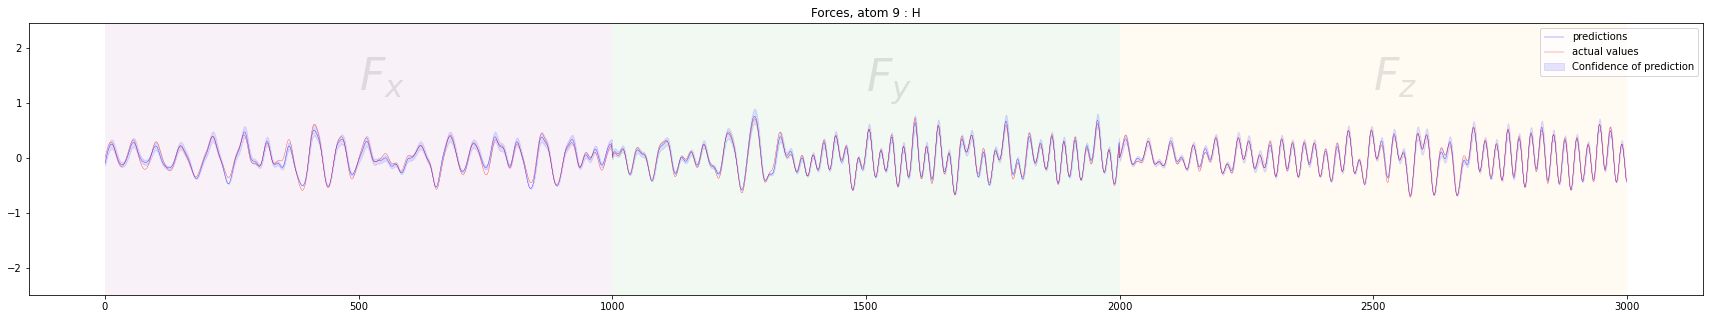

Forces MAE: 0.0357
Forces MSE: 0.0020
Cumulative uncertainty: 313.4426


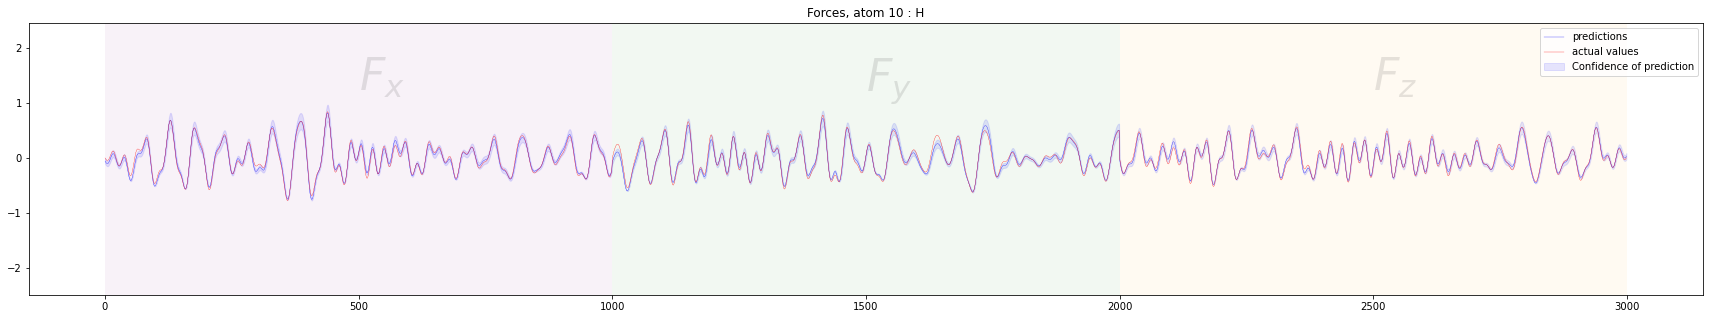

Forces MAE: 0.0326
Forces MSE: 0.0017
Cumulative uncertainty: 313.1301


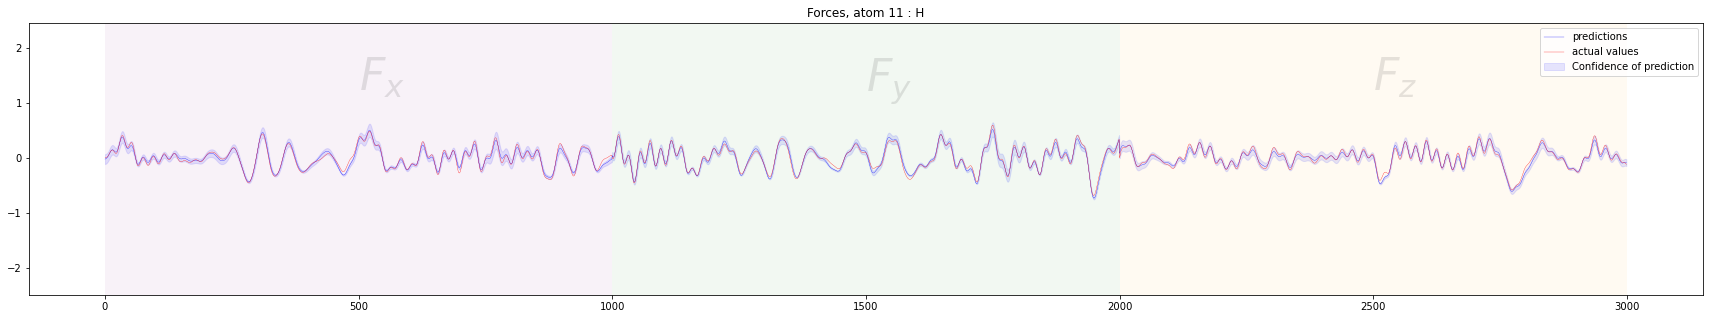

Forces MAE: 0.0274
Forces MSE: 0.0012
Cumulative uncertainty: 339.8261


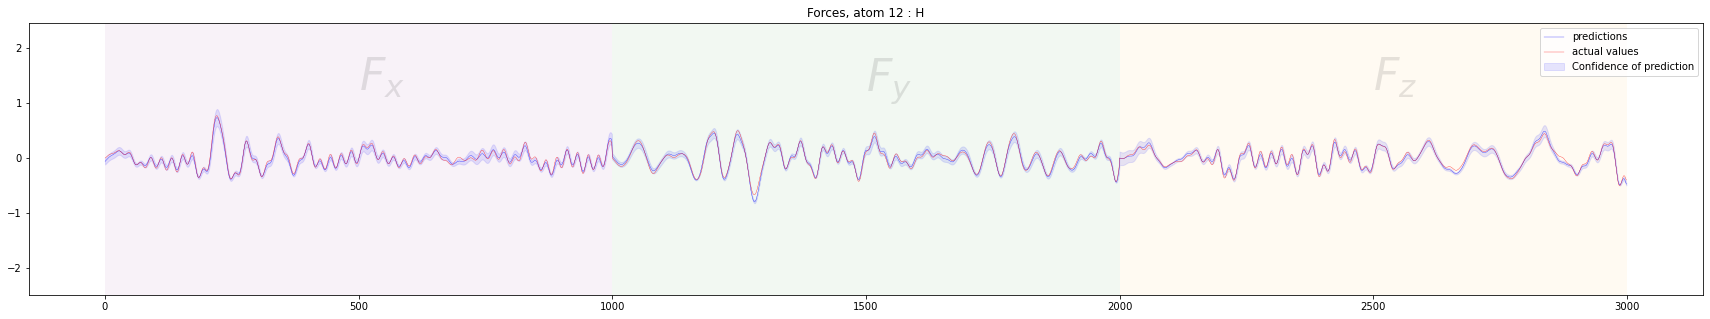

Forces MAE: 0.0256
Forces MSE: 0.0010
Cumulative uncertainty: 332.1192


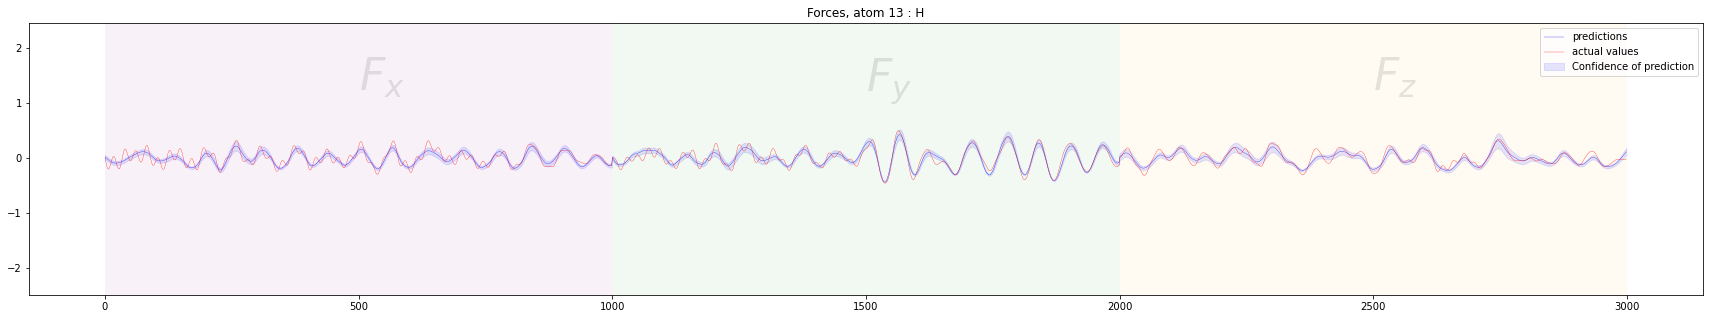

Forces MAE: 0.0534
Forces MSE: 0.0044
Cumulative uncertainty: 274.6832


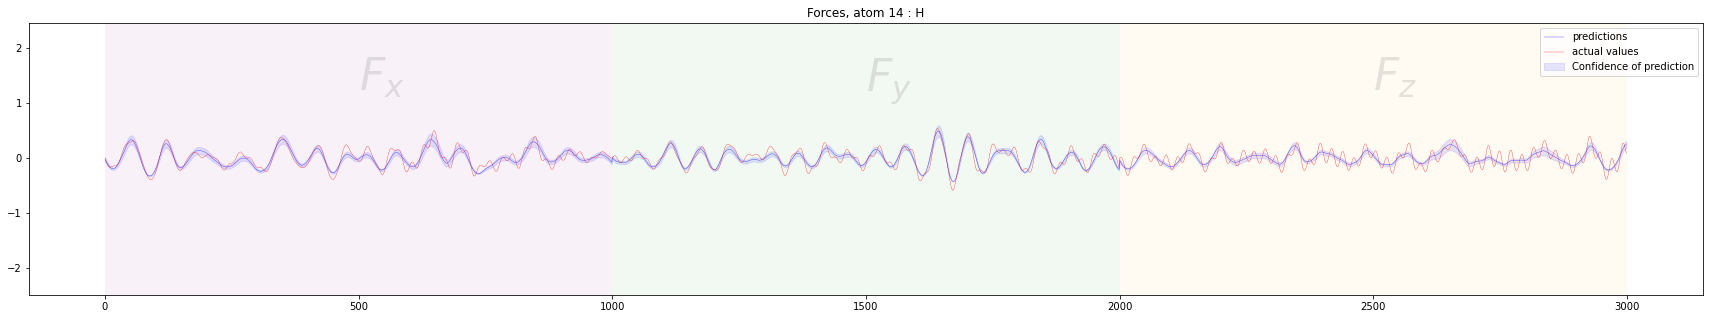

Forces MAE: 0.0683
Forces MSE: 0.0069
Cumulative uncertainty: 258.1059


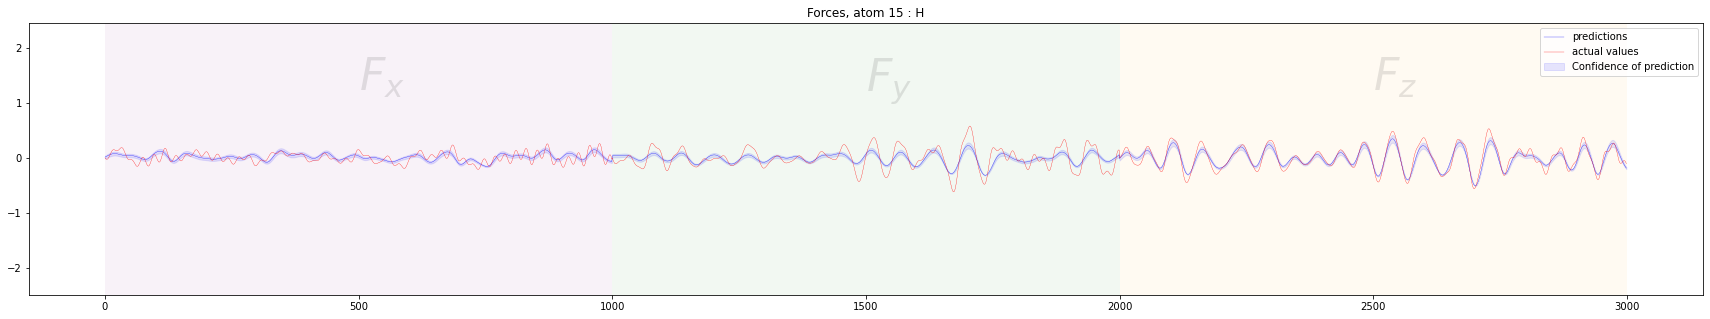

Forces MAE: 0.0767
Forces MSE: 0.0096
Cumulative uncertainty: 186.6682


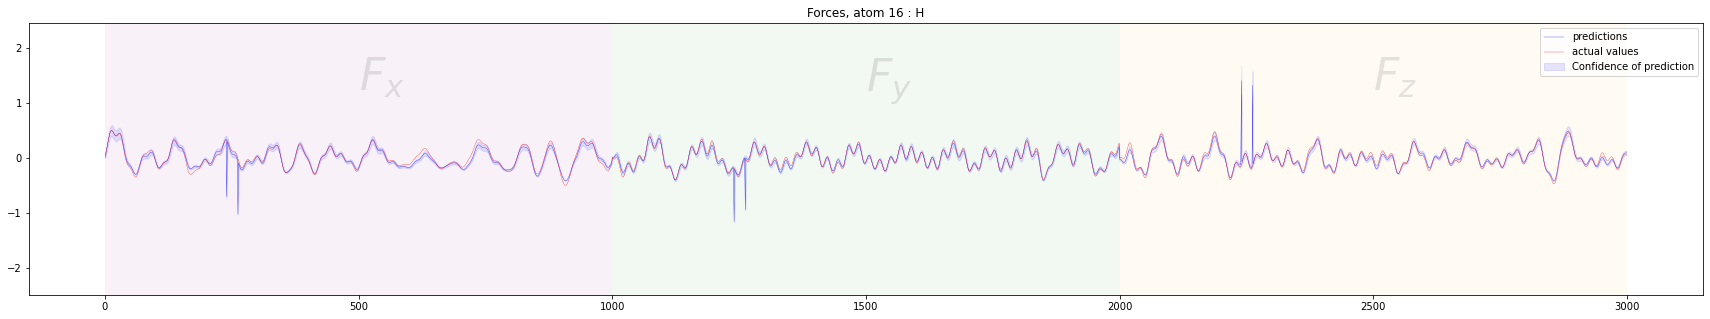

Forces MAE: 0.0303
Forces MSE: 0.0041
Cumulative uncertainty: 226.5629


In [929]:
from fande.predict import PredictorASE

test_X = fdm.test_X
test_DX = fdm.test_DX
test_E = fdm.test_E
test_F = fdm.test_F

model_e = None
trainer_e = None


predictor = PredictorASE(
            model_e,
            model_f,
            trainer_e,
            trainer_f,
            test_X,
            test_DX,
            test_E,
            test_F,
            test_data,
            hparams
)

predictor.predict_and_plot_forces()

### Dynamics simulation

In [ ]:
from sdynamics.dynamics import MDynamics

atoms = ... # initialize saddle structure

atoms.calc = gp_model.ase_calc() # get calc from the trained GP

md_runner = MDynamics(atoms) # instantiate class for running MD

md_runner.run() # run the MD

### Visualize:

In [519]:
from ase.visualize import view

# trj = trajectories[trj_files_basename[2]]
view(traj[0:100])
# view(traj[0:100])

<Popen: returncode: None args: ['/home/dlb/anaconda3/envs/pyc/bin/python', '...>

In [277]:
forces = fdm.forces_train[0]

traj[0].set_velocities(forces)

In [279]:
traj[0].get_velocities()

array([[-3.90522999e-04,  4.68570074e-03,  2.31874938e-03],
       [-5.37185370e-03, -1.36574150e-05,  8.30739807e-04],
       [-1.22377257e-03, -1.09553763e-02,  1.36464360e-03],
       [ 9.91943761e-04,  2.55279419e-03, -3.13065246e-03],
       [-1.27218775e-03, -1.32434891e-02, -1.11857372e-02],
       [ 7.68728430e-03,  9.74544106e-03, -7.57649694e-03],
       [ 1.20865503e-03,  5.43907481e-03,  1.49617786e-02],
       [-4.34298248e-03, -2.32720331e-03, -4.19559293e-03],
       [ 1.11949766e-03,  5.79979828e-04,  3.27397193e-03],
       [ 2.66445874e-03,  1.32920409e-03,  2.88248021e-03],
       [-6.67046476e-04,  2.56271864e-03, -3.49064641e-03],
       [ 3.98590183e-04,  1.22282798e-03,  2.57228870e-03],
       [ 5.73074166e-04, -8.30302240e-04, -1.74763154e-04],
       [-2.78975580e-03, -3.40333050e-05,  6.95041153e-04],
       [-1.88000470e-03,  6.16194170e-04, -1.16993422e-04],
       [-2.85754338e-04, -1.46566614e-03,  9.43701018e-04],
       [ 3.58037696e-03,  1.35792298e-04

In [287]:
traj[0].euler_rotate(phi=25, theta=33, psi=12, center=(0, 0, 0))
traj[0].rotate(90, (0, 0, 1))

In [293]:
mol_forces = traj[0].copy()

In [299]:
mol_forces.positions = forces 
mol_forces.euler_rotate(phi=25, theta=33, psi=12, center=(0, 0, 0))

forces_rotated = mol_forces.positions

In [300]:
forces_rotated

array([[ 2.62262794e-03,  4.51628554e-03, -4.58133085e-04],
       [-4.28003597e-03,  3.30822087e-03, -5.33004744e-04],
       [-7.10023872e-03, -5.80065875e-03,  6.27049516e-03],
       [ 1.91046366e-03, -5.24974587e-04, -3.65735228e-03],
       [-9.86821925e-03, -1.39609320e-02, -3.13684704e-03],
       [ 1.09590666e-02, -1.76066252e-03, -9.39522192e-03],
       [ 5.78460358e-03,  1.08898653e-02,  1.01414198e-02],
       [-5.33491973e-03, -1.43686715e-03, -3.36963148e-03],
       [ 1.61208369e-03,  1.52534128e-03,  2.71717941e-03],
       [ 3.25163219e-03,  9.81236793e-04,  2.37463229e-03],
       [ 5.26924412e-04,  1.77515595e-04, -4.34602451e-03],
       [ 1.31399906e-03,  1.95876529e-03,  1.64544723e-03],
       [-2.84360729e-05, -9.44128565e-04,  3.95184276e-04],
       [-2.20828735e-03,  1.84082736e-03, -4.24206151e-05],
       [-1.18923379e-03,  1.34769627e-03, -8.35007871e-04],
       [-9.62906790e-04, -3.05256085e-04,  1.44914928e-03],
       [ 2.99087657e-03, -1.81227464e-03

In [295]:
view(mol_forces)

<Popen: returncode: None args: ['/home/dlb/anaconda3/envs/pyc/bin/python', '...>